In [1]:
import numpy as np
from numpy.linalg import pinv, svd, eigvals
from scipy.linalg import svdvals

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# --> SciPy utility functions for discrete-time linear systems.
from scipy.signal import dlti, dlsim, lti, lsim

In [135]:
# --> Construct the matrices.
def build_system(ξ=0.05):
    # --> Dynamics matrix.
    A = np.array([
        [0.0, 1.0],
        [-1.0, -2*ξ]])
    
    # --> Input-to-state matrix.
    B = np.array([[0.0], [1.0]])
    
    # --> State-to-output matrix.
    C = np.array([[1.0, 0.0]])
    
    # --> Input-to-output matrix.
    D = np.array([[0.0]])
    
    return lti(A, B, C, D)

# --> Instantiate the system.
sys = build_system()

# --> Generate impulse response data.
t, y = sys.impulse(T=np.linspace(0, 200, 1001))
Δt = t[1] - t[0] # Sampling time.

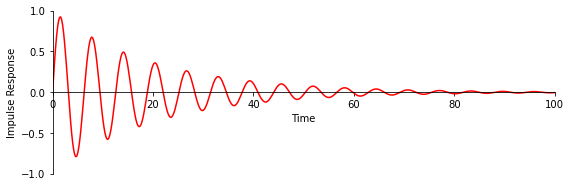

In [136]:
#--> Plot the Impulse Response.
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(t, y, c="r")

ax.set(xlim=(0, 100), ylim=(-1, 1))
ax.set(xlabel="Time", ylabel="Impulse Response")

ax.locator_params(axis="y", nbins=5)

ax.spines["bottom"].set_position("center")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [137]:
# --> Define Hankel matrix function.
def Hankel(y):
    
    # --> Ensure that we have an odd number of elements.
    if len(y)%2 != 0:
        y = y[:-1]
    
    # --> Size of the Hankel matrix.
    n = len(y)//2
    
    # --> Create the container.
    H = np.empty((n, n))
    
    # --> Fill-in the rows.
    for i in range(n):
        H[i, :] = y[i:-n+i]
        
    return H

In [138]:
# --> Extract the feedthrough matrix and discard y[0].
D, y_new = y[0], y[1:]

In [139]:
def era(y, Δt=1, rank=2, q=1, p=1):
    # --> Form the first Hankel matrix.
    H = Hankel(y[:-1])
    
    # --> Forms the one-step-ahead Hankel matrix.
    H̄ = Hankel(y[1:])

    # --> Singular Value Decomposition of the Hankel matrix.
    U, Σ, Vt = svd(H)

    # --> Extract only the relevant part of the decomposition.
    U, Vt = U[:, :rank], Vt[:rank]
    
    # --> Construct the observability and controlability matrices.
    Obs, Ctrb = U @ np.diag(np.sqrt(Σ[:rank])), np.diag(np.sqrt(Σ[:rank])) @ Vt    

    # --> Extract the state-to-output and input-to-stat matrices.
    C, B = Obs[:q].reshape(q, -1), Ctrb[:, :p].reshape(-1, p) 
    
    # --> Extract the dynamics matrix.
    A = pinv(Obs) @ H̄ @ pinv(Ctrb)

    # --> Wrap the system for easy simulation.
    sys = dlti(A, B, C, np.zeros((q, p)), dt=Δt)
    
    return sys, Σ, Obs, Ctrb

In [140]:
era_sys, Σ_era, Obs_era, Ctrb_era = era(y_new, Δt=Δt)

In [141]:
# --> Simulate the impulse response of the identified system.
_, y_era = era_sys.impulse(t=t)
y_era = y_era[0].flatten() # Extract the impulse (by default, impulse is more general and can handle multiple input/output)

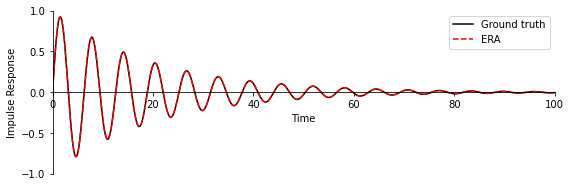

In [142]:
# --> Plot the Impulse Response.
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(t, y, c="k", label="Ground truth")
ax.plot(t, y_era, c="r", ls='--', label="ERA")

ax.set(xlim=(0, 100), ylim=(-1, 1))
ax.set(xlabel="Time", ylabel="Impulse Response")

ax.locator_params(axis="y", nbins=5)
ax.legend()

ax.spines["bottom"].set_position("center")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [143]:
def cca_era(y, Δt=1, rank=2, q=1, p=1):
    # --> Form the first Hankel matrix.
    X = Hankel(y[:-1])

    # --> Forms the one-step-ahead Hankel matrix.
    Y = Hankel(y[1:])

    Uy, Σy, Vy = svd(Y)
    Vy = Vy.T

    Ux, Σx, Vx = svd(X)
    Vx = Vx.T

    Σ = svdvals(np.diag(Σy) @ Vy.T @ Vx @ np.diag(Σx))
    
    Ux, Vx = Ux[:, :rank], Vx[:, :rank]
    Uy, Vy = Uy[:, :rank], Vy[:, :rank]

    Â, R, B̂t = svd(Vy.T @ Vx)
    B̂ = B̂t.T
    
    P = Uy @ pinv(np.diag(Σy[:rank])) @ Â
    Q = Ux @ pinv(np.diag(Σx[:rank])) @ B̂

    #Acca = Q.T @ pinv(P.T)

    Obs = pinv(Q.T)

    Ccca = Obs[:q].reshape(q, -1)

    Ctrb = pinv(Obs) @ X
    Bcca = Ctrb[:, :p].reshape(-1, p)
    Acca = pinv(Obs) @ Y @ pinv(Ctrb)
    
    # --> Wrap the system for easy simulation.
    sys = dlti(Acca, Bcca, Ccca, np.zeros((1, 1)), dt=Δt)
    
    return sys, Σ, Obs, Ctrb

In [144]:
cca_sys, Σ_cca, Obs_cca, Ctrb_cca = cca_era(y_new, Δt=Δt)

In [145]:
# --> Simulate the impulse response of the identified system.
_, y_cca = cca_sys.impulse(t=t)
y_cca = y_cca[0].flatten() # Extract the impulse (by default, impulse is more general and can handle multiple input/output)

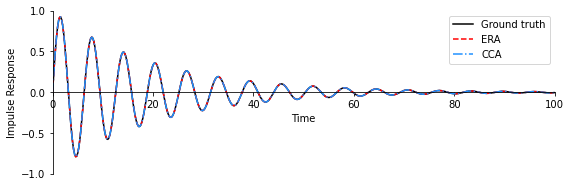

In [146]:
# --> Plot the Impulse Response.
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(t, y, c="k", label="Ground truth")
ax.plot(t, y_era, c="r", ls='--', label="ERA")
ax.plot(t, y_cca, c="dodgerblue", ls='-.', label="CCA")

ax.set(xlim=(0, 100), ylim=(-1, 1))
ax.set(xlabel="Time", ylabel="Impulse Response")

ax.locator_params(axis="y", nbins=5)
ax.legend()

ax.spines["bottom"].set_position("center")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [147]:
np.exp(eigvals(sys.A) * Δt)

array([0.97036393+0.1964498j, 0.97036393-0.1964498j])

In [148]:
eigvals(era_sys.A)

array([0.97036393+0.1964498j, 0.97036393-0.1964498j])

In [149]:
eigvals(cca_sys.A)

array([0.97036393+0.1964498j, 0.97036393-0.1964498j])

In [150]:
Obs_era.T @ Obs_era

array([[2.62880382e+01, 4.40240292e-15],
       [4.40240292e-15, 2.37712721e+01]])

In [151]:
Obs_cca.T @ Obs_cca

array([[ 6.91060951e+02, -4.91950231e-14],
       [-4.91950231e-14,  5.65073378e+02]])

In [152]:
Ctrb_era @ Ctrb_era.T

array([[ 2.62880382e+01, -2.46883677e-15],
       [-2.46883677e-15,  2.37712721e+01]])

In [153]:
Ctrb_cca @ Ctrb_cca.T

array([[ 1.00000000e+00, -1.56555406e-16],
       [-1.56555406e-16,  1.00000000e+00]])

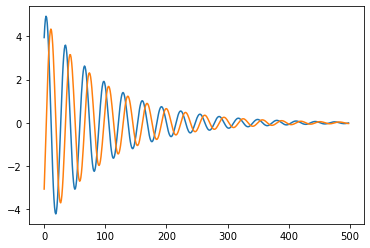

In [154]:
plt.plot(Obs_cca)

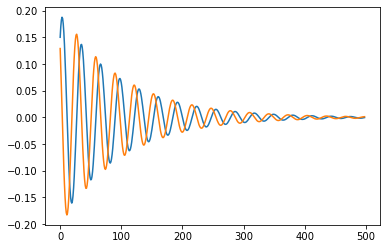

In [155]:
plt.plot(Ctrb_cca.T)